In [11]:
import os
import time
import copy
import glob
import cv2
import shutil
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [3]:
data_path = 'C:/080289-main/chap05/data/catanddog/train'

transform=transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])
train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)
print(len(train_dataset))

385


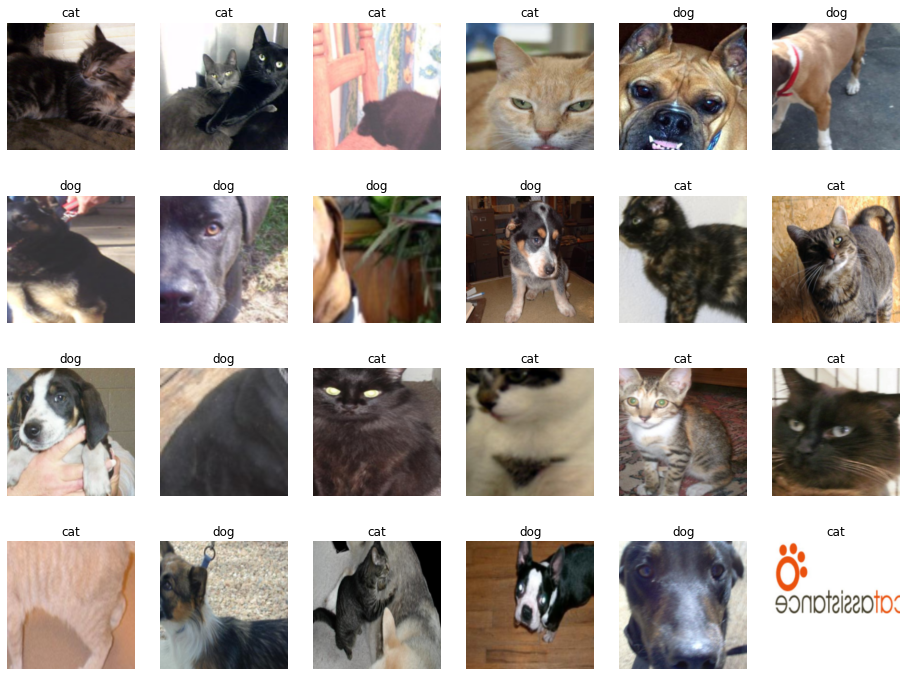

In [5]:
samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16, 24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [7]:
resnet18 = models.resnet18(pretrained=True)

In [8]:
def set_parameter_requires_gard(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_gard(resnet18)

In [12]:
resnet18.fc = nn.Linear(512,2)

In [13]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0361,  0.0173,  0.0405,  ..., -0.0111, -0.0415,  0.0242],
        [-0.0283, -0.0415,  0.0430,  ...,  0.0426,  0.0388,  0.0380]])
fc.bias tensor([0.0369, 0.0239])


In [14]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad=False
model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.rquires_grad=True
optimizer = torch.optim.Adam(model.fc.parameters())
cost=torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history=[]
    loss_history=[]
    best_acc=0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}' .format(epoch, num_epochs-1))
        print('-'*10)

        running_loss=0.0
        running_corrects=0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs) # -> 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() # -> 역전파 학습
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss:{:.4f} Acc:{:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('./data/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed%60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [25]:
params_to_update=[]
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print('\t', name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss:0.5929 Acc:0.6857

Epoch 1/12
----------
Loss:0.3774 Acc:0.8545

Epoch 2/12
----------
Loss:0.3359 Acc:0.8597

Epoch 3/12
----------
Loss:0.2704 Acc:0.9091

Epoch 4/12
----------
Loss:0.2378 Acc:0.9299

Epoch 5/12
----------
Loss:0.2867 Acc:0.8597

Epoch 6/12
----------
Loss:0.2237 Acc:0.9065

Epoch 7/12
----------
Loss:0.2377 Acc:0.8987

Epoch 8/12
----------
Loss:0.2352 Acc:0.8935

Epoch 9/12
----------
Loss:0.2403 Acc:0.9013

Epoch 10/12
----------
Loss:0.1951 Acc:0.9195

Epoch 11/12
----------
Loss:0.2380 Acc:0.8935

Epoch 12/12
----------
Loss:0.2489 Acc:0.8883

Training complete in 1m 13s
Best Acc: 0.929870


In [28]:
test_path = 'C:/080289-main/chap05/data/catanddog/test'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=1, shuffle=True)
print(len(test_dataset))

98


In [36]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history=[]
    best_acc=0.0

    saved_models=  glob.glob('./data/'+'*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path) 

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects=0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).cpu().int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed //60, time_elapsed%60))
    print('Best Acc : {:4f}'.format(best_acc))

    return acc_history


In [37]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./data\\00.pth', './data\\01.pth', './data\\02.pth', './data\\03.pth', './data\\04.pth', './data\\05.pth', './data\\06.pth', './data\\07.pth', './data\\08.pth', './data\\09.pth', './data\\10.pth', './data\\11.pth', './data\\12.pth']
Loading model ./data\00.pth
Acc: 0.8571

Loading model ./data\01.pth
Acc: 0.8673

Loading model ./data\02.pth
Acc: 0.9286

Loading model ./data\03.pth
Acc: 0.9388

Loading model ./data\04.pth
Acc: 0.9490

Loading model ./data\05.pth
Acc: 0.9286

Loading model ./data\06.pth
Acc: 0.9490

Loading model ./data\07.pth
Acc: 0.9490

Loading model ./data\08.pth
Acc: 0.9490

Loading model ./data\09.pth
Acc: 0.9592

Loading model ./data\10.pth
Acc: 0.9388

Loading model ./data\11.pth
Acc: 0.9490

Loading model ./data\12.pth
Acc: 0.9388

Validation complete in 0m 12s
Best Acc : 0.959184


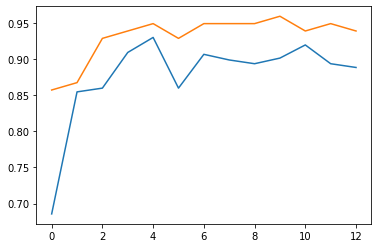

In [38]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

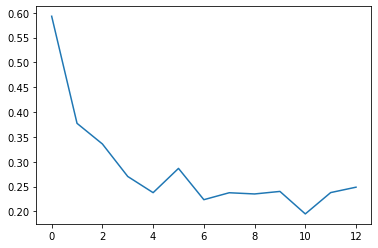

In [39]:
plt.plot(train_loss_hist)
plt.show()

In [40]:
# 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image*(np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
    iamge = image.clip(0,1)
    return image

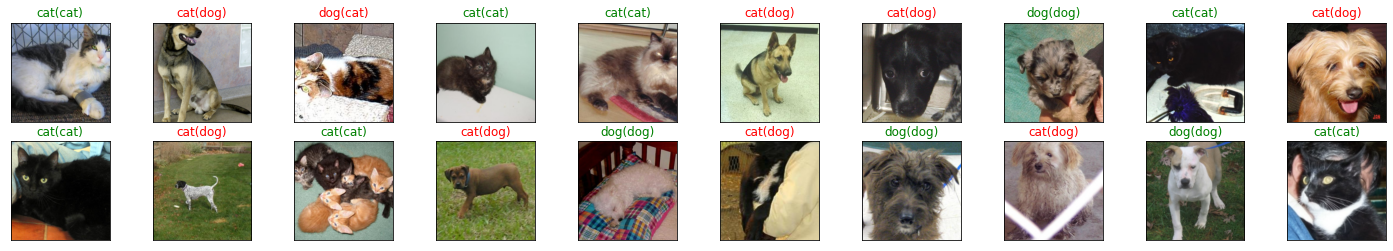

<Figure size 432x288 with 0 Axes>

In [48]:
classes = {0:'cat', 1:'dog'}
dataiter = iter(test_loader)
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    # a.set_title(classes[labels[i].item()])
    ax.set_title('{}({})'.format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=('green' if preds[idx]==labels[idx] else 'red'))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)